In [395]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


## Objectives

This section, we will focusing on making and tuning three models: Lasso, Ridge, and Elastic Net. We also have some small goals we want to achieve with different models:

    1. For the Lasso model, we would like to use it as a feature selection model and see which variables it would throw out for us.
    2. For the Ridge model, we would like to apply kernal trick, just like the one we used in the SVM.
    3. Our ultimate goal is to apply stacking with these models and observe the performance utilizing the stacking method.

In [270]:
train = pd.read_csv('data/train_preProcess.csv')
test = pd.read_csv('data/test_preProcess.csv')

In [271]:
train_y = train.SalePrice
train.drop(['SalePrice'], axis=1, inplace=True)

train.drop(['Id'], axis=1, inplace=True)

test_id = test['Id']
test.drop(['Id'], axis=1, inplace=True)

#df = pd.concat([train, test], axis= 0)

## Lasso

We will kick off with our model building with Lasso (L1 regularization).

In [296]:
lasso_reg = Lasso(random_state = 123, normalize= True)

In [297]:
lasso_grid = {'alpha': np.linspace(0, 1, 50)}

In [298]:
lasso_cv = GridSearchCV(estimator= lasso_reg, param_grid= lasso_grid,
                                cv=10, scoring="neg_mean_squared_error")

In [299]:
lasso_cv.fit(train, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=True, positive=False, precompute=False, random_state=123,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': array([ 0.     ,  0.02041,  0.04082,  0.06122,  0.08163,  0.10204,
        0.12245,  0.14286,  0.16327,  0.18367,  0.20408,  0.22449,
        0.2449 ,  0.26531,  0.28571,  0.30612,  0.32653,  0.34694,
        0.36735,  0.38776,  0.40816,  0.42857,  0.44898,  0.46939,
        0.4...673,
        0.85714,  0.87755,  0.89796,  0.91837,  0.93878,  0.95918,
        0.97959,  1.     ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [300]:
#best rmse score
np.sqrt(np.abs(lasso_cv.best_score_))

0.12492908464018486

In [301]:
lasso_best_params = lasso_cv.best_params_

In [302]:
#best params
lasso_best_params

{'alpha': 0.0}

In [311]:
lasso_reg = Lasso(alpha= 0.0, random_state=123)

In [12]:
lasso_coef = lasso_reg.fit(train, train_y).coef_

In [13]:
col_names = train.columns

In [78]:
lasso_coef_df = pd.DataFrame({'coef': lasso_coef},index=col_names)

In [83]:
lasso_coef_df = lasso_coef_df.sort_values(by='coef', ascending=False)

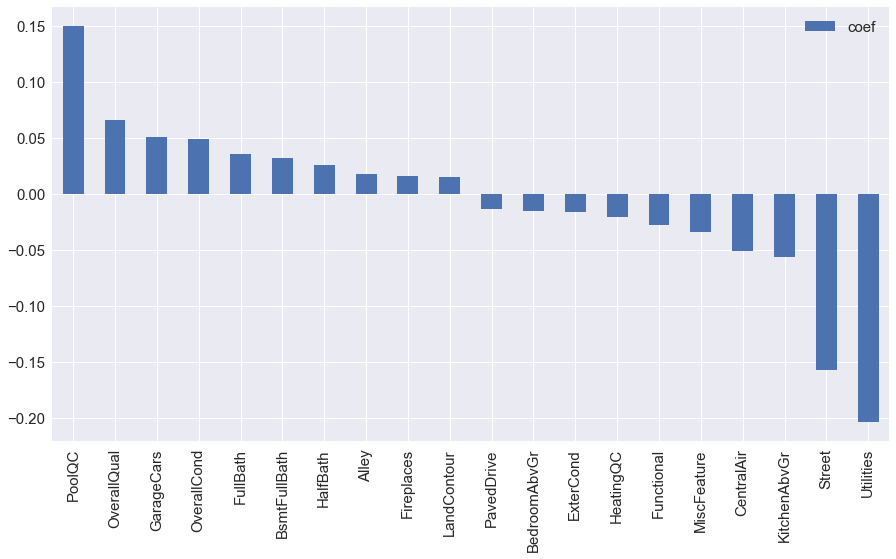

In [101]:
plt.rcParams['figure.figsize'] = (15, 8)
sns.set(font_scale=1.5)
pd.concat([lasso_coef_df.head(10), lasso_coef_df.tail(10)]).plot(kind = 'bar')

In [312]:
lasso_reg.fit(train, train_y)
lasso_preds = lasso_reg.predict(test)

In [314]:
#make pipeline for later stacking model
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0, random_state=123))

## Kernal Ridge and Ridge

### Kernal Ridge

In [103]:
ridge_kern_reg = KernelRidge(kernel='polynomial')

In [108]:
ridge_grid = {
    #"alpha":np.linspace(0, 1, 50),
    "alpha":[0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75],
    "coef0": np.arange(0, 5, 0.5),
    'degree': np.arange(1, 6, 1)
    
}

In [109]:
ridge_kern_cv = GridSearchCV(estimator=ridge_kern_reg, param_grid=ridge_grid,
                            cv=10, scoring="neg_mean_squared_error")

In [110]:
ridge_kern_cv.fit(train, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KernelRidge(alpha=1, coef0=1, degree=3, gamma=None, kernel='polynomial',
      kernel_params=None),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'degree': array([1, 2, 3, 4, 5]), 'coef0': array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5]), 'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [111]:
ridge_kern_cv.best_params_

{'alpha': 0.05, 'coef0': 4.5, 'degree': 1}

In [114]:
np.sqrt(np.abs(ridge_kern_cv.best_score_))

0.12493788085916019

In [315]:
ridge_kern = KernelRidge(alpha= 0.05, kernel = "polynomial",
                        degree = 1, coef0 = 4.5)

In [316]:
ridge_kern.fit(train, train_y)
ridge_kern_pred = ridge_kern.predict(test)

In [320]:
ridge_kern = make_pipeline(RobustScaler(), KernelRidge(alpha=0.05,degree = 1, coef0 = 4.5))

### Ridge

In [276]:
ridge_reg = Ridge(random_state=123, normalize=True)

In [277]:
ridge_grid = {
    'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
}

In [278]:
ridge_cv = GridSearchCV(estimator= ridge_reg, param_grid= ridge_grid,
                        cv=10, scoring="neg_mean_squared_error")

In [279]:
ridge_cv.fit(train, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=123, solver='auto', tol=0.001),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'alpha': [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [280]:
np.sqrt(np.abs(ridge_cv.best_score_))

0.12476136849004964

In [281]:
ridge_cv.best_params_

{'alpha': 0.05}

In [324]:
ridge_reg = Ridge(alpha= 0.05, random_state=123)
ridge_reg.fit(train, train_y)
ridge_pred = ridge_reg.predict(test)

In [282]:
ridge= make_pipeline(RobustScaler(), Ridge(alpha=0.05, random_state=123))

## ENet

In [283]:
ENet_reg = ElasticNet(random_state=123)

In [284]:
ENet_grid = {
    'alpha': np.arange(0, 0.2, 0.001),
    'l1_ratio': np.linspace(0, 1, 30)
}

In [285]:
ENet_cv = GridSearchCV(estimator= ENet_reg, param_grid= ENet_grid,
                      cv=10, scoring="neg_mean_squared_error")

In [286]:
ENet_cv.fit(train, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=123, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'l1_ratio': array([ 0.     ,  0.03448,  0.06897,  0.10345,  0.13793,  0.17241,
        0.2069 ,  0.24138,  0.27586,  0.31034,  0.34483,  0.37931,
        0.41379,  0.44828,  0.48276,  0.51724,  0.55172,  0.58621,
        0.62069,  0.65517,  0.68966,  0.72414,  0.75862,  0.7931 ,
        0.82759,  0.86207,  0.89655,  0.93103,  0.96552,  1.     ]), 'alpha': array([ 0.   ,  0.001, ...,  0.198,  0.199])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [287]:
np.sqrt(np.abs(ENet_cv.best_score_))

0.12480675925022992

In [288]:
enet_best_params = ENet_cv.best_params_

In [289]:
enet_best_params

{'alpha': 0.001, 'l1_ratio': 0.37931034482758619}

In [328]:
ENet_reg = ElasticNet(alpha= 0.001, l1_ratio=0.37931034482758619, 
                    random_state=123)

ENet_reg.fit(train, train_y)
ENet_pred = ENet_reg.predict(test)

In [292]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha= 0.001, l1_ratio=0.37931034482758619, 
                    random_state=123))

## Stacking using all models

In [338]:
models = [lasso, ridge, ridge_kern]
meta_model = [ENet]

In [362]:
#create an empty list in insert predictions from each model 
out_of_fold_predictions = np.zeros((train.shape[0], len(models)))
#we are going to split the training set to 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

#gather all the model parameters into a list so we can iterate over it
base_models = [list() for x in models]

for i, model in enumerate(models):
    #create training set and holdout set with "kfold"
    for train_index, holdout_index in kfold.split(train.values, train_y.values):
        #iterate through models
        model = models[i]
        base_models[i].append(model)
        #fit training set with current model
        model.fit(train.values[train_index], train_y.values[train_index])
        #predict with holdout set with current model
        y_pred = model.predict(train.values[holdout_index])
        #add predictions to out_of_fold_predictions
        out_of_fold_predictions[holdout_index, i] = y_pred
        
    #after iterate through all the models, we would fit meta model with out_of_fold preds
    meta_model[0].fit(out_of_fold_predictions, train_y.values)

In [388]:
out_of_bag_preds  = np.zeros((train.shape[0], len(models)))

#retrain all models with the whole training data
for i, model in enumerate(models):
    model = models[i]
    model.fit(train.values, train_y)
    y_pred = model.predict(train.values)
    #insert prediction of current model to the list
    out_of_bag_preds[:, i] = y_pred

#calculate cv scores
cv_score = cross_val_score(meta_model[0], out_of_bag_preds, train_y, cv=10, scoring="neg_mean_squared_error")
print("the 10-fold cv score is: ", np.mean(np.sqrt(np.abs(cv_score))))
#predict out_of_bag_preds with meta model
final_pred = meta_model[0].predict(out_of_bag_preds)

the 10-fold cv score is:  0.11620250061


### Adding KNN

In [455]:
n_neighbors = np.arange(3, 51, 2)
knn_reg = KNeighborsRegressor(weights='distance')

In [456]:
knn_grid = {
    "n_neighbors" : n_neighbors
}

In [457]:
KNN_cv = GridSearchCV(estimator= knn_reg , param_grid= knn_grid,
                      cv=10, scoring="neg_mean_squared_error")

In [458]:
KNN_cv.fit(train, train_y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=5, p=2,
          weights='distance'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [459]:
np.sqrt(np.abs(KNN_cv.best_score_))

0.23883489754381468

In [460]:
KNN_cv.best_params_

{'n_neighbors': 7}

In [506]:
KNN = make_pipeline(RobustScaler(), KNeighborsRegressor(n_neighbors= 7, weights='distance'))

In [513]:
models = [ENet, ridge, ridge_kern, KNN]
meta_model = [lasso]

In [514]:
#create an empty list in insert predictions from each model 
out_of_fold_predictions = np.zeros((train.shape[0], len(models)))
#we are going to split the training set to 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

#gather all the model parameters into a list so we can iterate over it
base_models = [list() for x in models]

for i, model in enumerate(models):
    #create training set and holdout set with "kfold"
    for train_index, holdout_index in kfold.split(train.values, train_y.values):
        #iterate through models
        model = models[i]
        base_models[i].append(model)
        #fit training set with current model
        model.fit(train.values[train_index], train_y.values[train_index])
        #predict with holdout set with current model
        y_pred = model.predict(train.values[holdout_index])
        #add predictions to out_of_fold_predictions
        out_of_fold_predictions[holdout_index, i] = y_pred
        
    #after iterate through all the models, we would fit meta model with out_of_fold preds
    meta_model[0].fit(out_of_fold_predictions, train_y.values)
    

out_of_bag_preds  = np.zeros((train.shape[0], len(models)))

#retrain all models with the whole training data
for i, model in enumerate(models):
    model = models[i]
    model.fit(train.values, train_y)
    y_pred = model.predict(train.values)
    #insert prediction of current model to the list
    out_of_bag_preds[:, i] = y_pred

#calculate cv scores
cv_score = cross_val_score(meta_model[0], out_of_bag_preds, train_y, cv=10, scoring="neg_mean_squared_error")
print("the 10-fold cv score is: ", np.mean(np.sqrt(np.abs(cv_score))))
#predict out_of_bag_preds with meta model
final_pred = meta_model[0].predict(out_of_bag_preds)

the 10-fold cv score is:  0.000164121868944


### Making Prediction

In [515]:
#create an empty list in insert predictions from each model 
out_of_fold_predictions = np.zeros((train.shape[0], len(models)))
#we are going to split the training set to 5 folds
kfold = KFold(n_splits=5, shuffle=True, random_state=123)

#gather all the model parameters into a list so we can iterate over it
base_models = [list() for x in models]

for i, model in enumerate(models):
    #create training set and holdout set with "kfold"
    for train_index, holdout_index in kfold.split(train.values, train_y.values):
        #iterate through models
        model = models[i]
        base_models[i].append(model)
        #fit training set with current model
        model.fit(train.values[train_index], train_y.values[train_index])
        #predict with holdout set with current model
        y_pred = model.predict(train.values[holdout_index])
        #add predictions to out_of_fold_predictions
        out_of_fold_predictions[holdout_index, i] = y_pred
        
    #after iterate through all the models, we would fit meta model with out_of_fold preds
    meta_model[0].fit(out_of_fold_predictions, train_y.values)

In [516]:
out_of_bag_preds  = np.zeros((test.shape[0], len(models)))

#retrain all models with the whole training data
for i, model in enumerate(models):
    model = models[i]
    model.fit(train.values, train_y)
    y_pred = model.predict(test.values)
    #insert prediction of current model to the list
    out_of_bag_preds[:, i] = y_pred

#predict out_of_bag_preds with meta model
final_pred = meta_model[0].predict(out_of_bag_preds)

In [517]:
final_pred = np.exp(final_pred) - 1

In [518]:
df_sub = pd.DataFrame({'id': test_id, "SalePrice":final_pred})
df_sub.to_csv('GLM_stacking_out.csv', index=False)

Submitting our prediction to Kaggle, we have have RMSE equals to 0.12955, which is pretty close to XGBoost's score we submitted earlier (0.12432). Let's implement XGBoost into our stacking next.